In [1]:
# -*- coding: utf-8 -*-
"""rise_spatial_multiplicative_norm_zero_cineca.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1-4UndkKCTVbDRQZql3km54NZicEG05gb

### ***Cineca***
"""

import tensorflow as tf
#from tensorflow.keras import layers, activations, callbacks, models
import numpy as np
import pickle
import os
from keras.models import load_model
from skimage.transform import resize
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sys
# Save Execution Time
import datetime

"""

##### ***Data & Black-Box***

"""

RESULT_DIR = str(sys.argv[1])
print(f"RESULT_DIR: {RESULT_DIR}")

# IMPORTO I DATI PER VOTTIGNASCO
# Ottieni il percorso effettivo da una variabile d'ambiente
work_path = os.environ['WORK']  # Ottieni il valore della variabile d'ambiente WORK
v_test_OHE_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_month_OHE.npy")
v_test_image_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_normalized_image_sequences.npy")
v_test_target_dates_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/Vottignasco_00425010001_test_target_dates.npy")
v_test_normalization_factors_std_path  = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_std.npy")
v_test_normalization_factors_mean_path = os.path.join(work_path, "Water_Resources/rise-video/data/Vottignasco/normalization_factors/Vottignasco_00425010001_training_target_mean.npy")

# Carica l'array numpy dai file
vottignasco_test_OHE    = np.load(v_test_OHE_path)
vottignasco_test_image  = np.load(v_test_image_path)
vottignasco_test_dates  = np.load(v_test_target_dates_path)
vott_target_test_std    = np.load(v_test_normalization_factors_std_path) 
vott_target_test_mean   = np.load(v_test_normalization_factors_mean_path)

print(len(vottignasco_test_dates))
print(len(vottignasco_test_image))
print(len(vottignasco_test_OHE))

#print(vottingasco_test_OHE[0], "\n")
#print(vottignasco_test_image[0][0], "\n")

# """##### ***Black Boxes***""

# Se vuoi abilitare il dropout a runtime
mc_dropout = True

# Definizione della classe personalizzata doprout_custom
class doprout_custom(tf.keras.layers.SpatialDropout1D):
    def call(self, inputs, training=None):
        if mc_dropout:
            return super().call(inputs, training=True)
        else:
            return super().call(inputs, training=False)

# Percorso della directory su Cineca
base_dir = os.path.join(os.environ['WORK'], "Water_Resources/rise-video/trained_models/seq2val/Vottignasco")
lstm_suffix = 'time_dist_LSTM'

vott_lstm_models = []

def extract_index(filename):
    """Funzione per estrarre l'indice finale dal nome del file."""
    return int(filename.split('_LSTM_')[-1].split('.')[0])

# Trova tutti i file .keras nella cartella e li aggiunge alla lista
for filename in os.listdir(base_dir):
    if lstm_suffix in filename and filename.endswith(".keras"):
        vott_lstm_models.append(os.path.join(base_dir, filename))

# Ordina i modelli in base all'indice finale
vott_lstm_models = sorted(vott_lstm_models, key=lambda x: extract_index(os.path.basename(x)))

# Lista per i modelli caricati
vott_lstm_models_loaded = []

for i, model_lstm_path in enumerate(vott_lstm_models[:10]):  # Prendo i primi 10 modelli ordinati
    #print(f"Caricamento del modello LSTM {i+1}: {model_lstm_path}")

    # Carico il modello con la classe custom
    model = load_model(model_lstm_path, custom_objects={"doprout_custom": doprout_custom})

    # Aggiungo il modello alla lista
    vott_lstm_models_loaded.append(model)

print(vott_lstm_models_loaded)

import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_rise_masks_2d(N, input_size, seed, **kwargs):
    """
    Genera N maschere RISE per un'immagine di dimensioni HxW.

    Parametri:
    - N: numero di maschere
    - input_size: (H,W) dimensioni dell'immagine originale
    - h, w: dimensioni delle maschere a bassa risoluzione
    - p: probabilità di attivazione dei pixel nella maschera binaria iniziale

    Ritorna:
    - masks: array di shape (N, H, W) contenente le maschere normalizzate.
    """

    h  = kwargs.get("h", 2)
    w = kwargs.get("w", 2)
    p = kwargs.get("p", 0.5)

    np.random.seed(seed)

    masks = []
    H,W = input_size
    CH, CW = H // h, W // w  # Fattore di upscaling

    for _ in range(N):
        # 1. Generazione della maschera binaria iniziale (h x w)
        small_mask = np.random.rand(h, w) < p

        up_size_h = (h+1) * CH
        up_size_w = (w+1) * CW

        # 2. Upsampling bilineare alla dimensione (H + CH, W + CW
        upsampled_mask = cv2.resize(small_mask.astype(np.float32),
                                    (up_size_w, up_size_h), interpolation=cv2.INTER_LINEAR)
        
        #print(upsampled_mask.shape)
        
        # 3. Crop casuale della regione H x W
        x_offset = np.random.randint(0, (up_size_h - H) + 1)
        y_offset = np.random.randint(0, (up_size_w - W) + 1)
        final_mask = upsampled_mask[x_offset:x_offset + H, y_offset:y_offset + W] 

        #print(final_mask.shape)

        masks.append(final_mask)

    masks = np.array(masks)  # Converte la lista in array NumPy
    masks = masks[~(masks == 0).all(axis=(1, 2))]  # Filtro maschere vuote
    masks = masks[~(masks == 1.0).all(axis=(1, 2))]  # Filtro maschere con tutti 1.0


    return np.array(masks)


def multiplicative_uniform_noise_onechannel(images, masks, channel, **kwargs):
    std_zero_value = kwargs.get("std_zero_value", -0.6486319166678826)

    masked = []

    # Itero su tutte le N maschere generate
    for mask in masks:
        masked_images = copy.deepcopy(images)  # Copia profonda delle immagini originali

        # Applica la perturbazione solo al canale specificato
        masked_images[..., channel] = (
            masked_images[..., channel] * mask + (1 - mask) * std_zero_value)

        masked.append(masked_images)

    return masked

def ensemble_predict(models, images, x3_exp, batch_size=1000):
    # Assicuriamoci che images sia una lista
    if not isinstance(images, list):
        images = [images]

    len_x3 = len(images)

    # Convertiamo x3_exp in un tensore replicato per ogni immagine
    x3_exp_tensor = tf.convert_to_tensor(x3_exp, dtype=tf.float32)

    # Lista per raccogliere le predizioni finali
    final_preds = []

    # Processamento a batch
    for i in range(0, len_x3, batch_size):
        batch_images = images[i:i + batch_size]
        batch_len = len(batch_images)

        # Conversione batch in tensori
        Y_test = tf.stack([tf.convert_to_tensor(img, dtype=tf.float32) for img in batch_images])
        Y_test_x3 = tf.tile(tf.expand_dims(x3_exp_tensor, axis=0), [batch_len, 1, 1])

        # Raccoglie le predizioni di tutti i modelli per il batch corrente
        batch_preds = []

        for model in models:
            preds = model.predict([Y_test, Y_test_x3], verbose=0)
            batch_preds.append(preds)

        # Converte le predizioni del batch in un tensore e calcola la media
        batch_preds_tensor = tf.stack(batch_preds)
        mean_batch_preds = tf.reduce_mean(batch_preds_tensor, axis=0)

        # Aggiunge le predizioni del batch alla lista finale
        final_preds.extend(mean_batch_preds.numpy())

    return np.array(final_preds)



2025-03-08 18:30:04.255742: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 18:30:05.838476: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 18:30:10.453012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-08 18:30:10.456156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-08 18:30:11.049367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

RESULT_DIR: --f=/run/user/129071/jupyter/runtime/kernel-v38aac22bcb0a736cf6051e3b04c3aed2db6eae91e.json
105
105
105
[<keras.src.engine.functional.Functional object at 0x7f300129c760>, <keras.src.engine.functional.Functional object at 0x7f3000a5f7c0>, <keras.src.engine.functional.Functional object at 0x7f2ffa5d7d00>, <keras.src.engine.functional.Functional object at 0x7f2ffa466d40>, <keras.src.engine.functional.Functional object at 0x7f2ffa4be1d0>, <keras.src.engine.functional.Functional object at 0x7f2ffa52e680>, <keras.src.engine.functional.Functional object at 0x7f2ffa4441f0>, <keras.src.engine.functional.Functional object at 0x7f2ffa3ca080>, <keras.src.engine.functional.Functional object at 0x7f2ffa2539a0>, <keras.src.engine.functional.Functional object at 0x7f2ffa2c2bf0>]


In [2]:
"""#### ***Saliency Map***"""

# Modifica della funzione per calcolare la mappa di salienza introducendo anche -> E[M] cioè il valore atteso delle Maschere

def calculate_saliency_map_ev_masks(N, weights, masks):
    """
    Calcola la mappa di salienza media data una serie di predizioni e maschere.

    :param weights_array: Array di predizioni (pesi delle maschere).
    :param masks: Array di maschere (numero di maschere x dimensioni maschera).
    :return: Mappa di salienza media.
    """
    sal = []

    H, W = masks.shape[1], masks.shape[2]
    
    for j in range(len(masks)):
        sal_j = weights[j] * masks[j]
        sal.append(sal_j.reshape(-1, H, W))

    # Ora calcola la media lungo l'asse 0
    ev_masks = np.mean(masks, axis=0)

    sal = (1/(ev_masks * N)) * np.mean(sal, axis=0)  # aggiunta della frazione 1/valore_atteso(maschere)

    return np.squeeze(sal)

In [54]:
data_test_image = vottignasco_test_image
data_test_OHE   = vottignasco_test_OHE
models = vott_lstm_models_loaded
H_station = 390.0
nr_instance = 0

seed = 42
channel = 0

h,w = 2,4
p   = 0.5

N = 1000

instance    = copy.deepcopy(data_test_image[nr_instance])
x3_instance = copy.deepcopy(data_test_OHE[nr_instance])

input_size = (instance.shape[1], instance.shape[2])

masks = generate_rise_masks_2d(N, input_size, seed, h=h, w=w, p=p)
perturbed_instances = multiplicative_uniform_noise_onechannel(instance, masks, channel)

# Predizione su Istanza Originale
pred_original = ensemble_predict(models, instance, x3_instance)
# Predizioni su Istanze Perturbate
preds_masked = ensemble_predict(models, perturbed_instances, x3_instance)

# Denormalizzazione output della black-box con H_station
denorm_pred_original = (pred_original * vott_target_test_std) + vott_target_test_mean
denorm_preds_masked  = [(pred_masked * vott_target_test_std) + vott_target_test_mean for pred_masked in preds_masked]
denormalized_H_pred_original = H_station - denorm_pred_original
denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]


S1 per istanza #0: [[0.38453528 0.38456857 0.38461208 0.38463557 0.3846242  0.38459763
  0.38458076 0.3845785 ]
 [0.38454068 0.3845728  0.38462016 0.38464803 0.38463867 0.38460815
  0.38458484 0.38457903]
 [0.38454905 0.38457775 0.38462317 0.3846534  0.3846467  0.3846133
  0.38458213 0.38457182]
 [0.38455638 0.38458166 0.3846257  0.38465863 0.38465452 0.3846184
  0.38457957 0.38456464]
 [0.3845591  0.3845821  0.38462174 0.38465202 0.38464844 0.38461262
  0.38457283 0.3845567 ]]


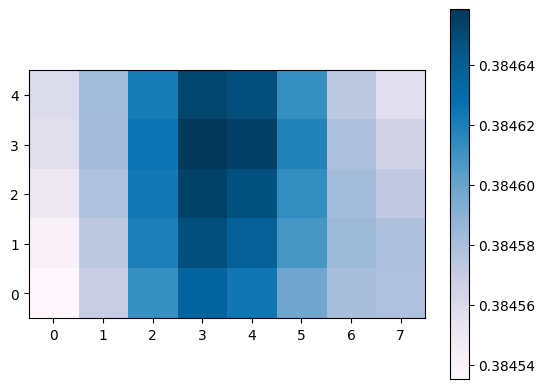

In [47]:
### S1 
weights = np.concatenate(denormalized_H_preds_masked, axis=0)
s1_i = calculate_saliency_map_ev_masks(N, weights, masks)
print("S1 per istanza #0:", s1_i)
plt.imshow(s1_i, origin="lower", cmap="PuBu")
plt.colorbar()

S2 per istanza #0: [[147.71973 147.74548 147.7783  147.79668 147.78848 147.76901 147.75537
  147.75255]
 [147.72426 147.74893 147.7845  147.80629 147.79936 147.7766  147.75844
  147.75362]
 [147.73111 147.7527  147.787   147.81047 147.80565 147.78017 147.75632
  147.74835]
 [147.73776 147.7561  147.78946 147.81454 147.81181 147.78377 147.75424
  147.74318]
 [147.7401  147.75624 147.78618 147.80968 147.8074  147.77937 147.7488
  147.73654]]


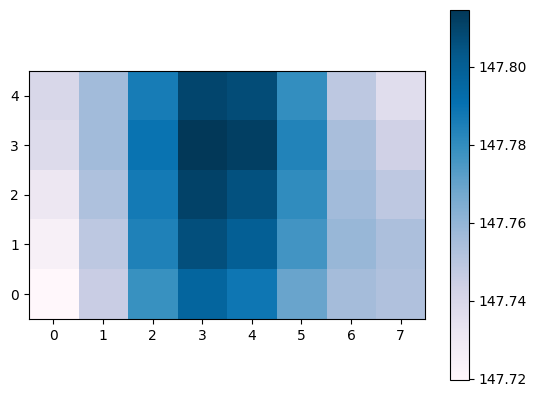

[(0, 0),
 (1, 0),
 (2, 0),
 (4, 7),
 (3, 0),
 (4, 0),
 (3, 7),
 (0, 1),
 (2, 7),
 (4, 6),
 (1, 1),
 (0, 7),
 (2, 1),
 (1, 7),
 (3, 6),
 (0, 6),
 (3, 1),
 (4, 1),
 (2, 6),
 (1, 6),
 (0, 5),
 (1, 5),
 (0, 2),
 (4, 5),
 (2, 5),
 (3, 5),
 (1, 2),
 (4, 2),
 (2, 2),
 (0, 4),
 (3, 2),
 (0, 3),
 (1, 4),
 (2, 4),
 (1, 3),
 (4, 4),
 (4, 3),
 (2, 3),
 (3, 4),
 (3, 3)]

In [76]:
### S2 
weights = np.concatenate(denormalized_H_preds_masked, axis=0)
s2_i = calculate_saliency_map_ev_masks(N, weights**2, masks) - (s1_i**2)
print("S2 per istanza #0:", s2_i)
plt.imshow(s2_i, origin="lower", cmap="PuBu")
plt.colorbar()
plt.show()

all_important_pixels_s2 = get_top_n_pixels(s2_i, 40)[::-1]
all_important_pixels_s2

BIAS:  [[-385.07086 -385.0708  -385.07077 -385.07074 -385.07077 -385.07077
  -385.0708  -385.0708 ]
 [-385.07083 -385.0708  -385.07077 -385.07074 -385.07074 -385.07077
  -385.0708  -385.0708 ]
 [-385.07083 -385.0708  -385.07077 -385.07074 -385.07074 -385.07077
  -385.0708  -385.0708 ]
 [-385.07083 -385.0708  -385.07077 -385.0707  -385.07074 -385.07077
  -385.0708  -385.07083]
 [-385.07083 -385.0708  -385.07077 -385.07074 -385.07074 -385.07077
  -385.0708  -385.07083]]


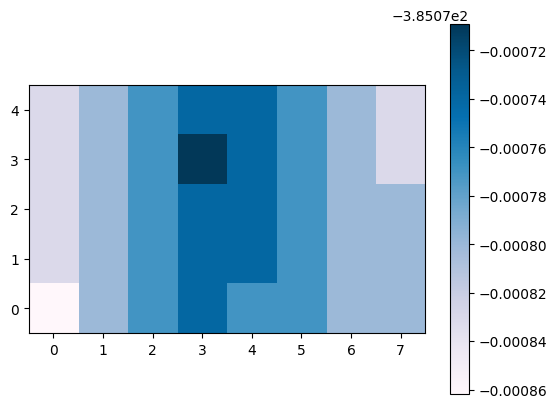

In [32]:
## S3
s3_i = (s1_i - denormalized_H_pred_original)
print("BIAS: ", s3_i)
plt.imshow(s3_i, origin="lower", cmap="PuBu")
plt.colorbar()

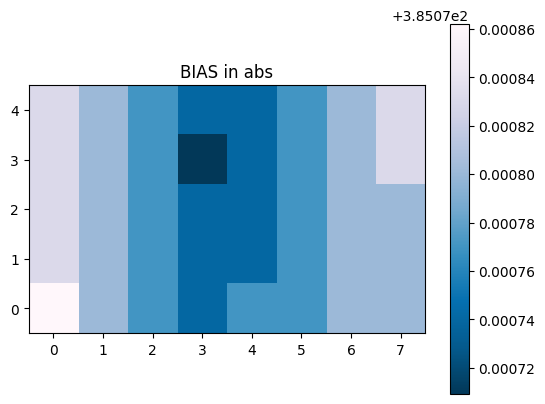

[(3, 3),
 (0, 3),
 (1, 4),
 (1, 3),
 (2, 4),
 (3, 4),
 (2, 3),
 (4, 3),
 (4, 4),
 (2, 5),
 (2, 2),
 (3, 2),
 (1, 2),
 (1, 5),
 (3, 5),
 (0, 2),
 (4, 2),
 (4, 5),
 (0, 5),
 (0, 4),
 (3, 6),
 (2, 7),
 (1, 1),
 (1, 7),
 (3, 1),
 (2, 6),
 (2, 1),
 (4, 6),
 (0, 6),
 (0, 1),
 (0, 7),
 (1, 6),
 (4, 1),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (3, 7),
 (4, 7),
 (0, 0)]

In [71]:
plot_frame(np.abs(s3_i), cmap="PuBu_r", title="BIAS in abs")

all_important_pixels_s3 = get_top_n_pixels(np.abs(s3_i), instance.shape[1]*instance.shape[2])[::-1]
all_important_pixels_s3

In [33]:
s3_i

array([[-385.07086, -385.0708 , -385.07077, -385.07074, -385.07077,
        -385.07077, -385.0708 , -385.0708 ],
       [-385.07083, -385.0708 , -385.07077, -385.07074, -385.07074,
        -385.07077, -385.0708 , -385.0708 ],
       [-385.07083, -385.0708 , -385.07077, -385.07074, -385.07074,
        -385.07077, -385.0708 , -385.0708 ],
       [-385.07083, -385.0708 , -385.07077, -385.0707 , -385.07074,
        -385.07077, -385.0708 , -385.07083],
       [-385.07083, -385.0708 , -385.07077, -385.07074, -385.07074,
        -385.07077, -385.0708 , -385.07083]], dtype=float32)

In [34]:
s2_i

array([[147.7202 , 147.74571, 147.77864, 147.79704, 147.78897, 147.76965,
        147.75616, 147.75333],
       [147.72525, 147.74994, 147.78517, 147.80661, 147.79991, 147.77734,
        147.75919, 147.75377],
       [147.73207, 147.75381, 147.78816, 147.81104, 147.80627, 147.78119,
        147.7569 , 147.74812],
       [147.73824, 147.75758, 147.79079, 147.81534, 147.81259, 147.78508,
        147.75476, 147.74231],
       [147.73993, 147.75745, 147.7877 , 147.81067, 147.80826, 147.78079,
        147.7495 , 147.73592]], dtype=float32)

RMSE:  [[385.2626  385.2626  385.2626  385.2626  385.2626  385.2626  385.2626
  385.2626 ]
 [385.2626  385.2626  385.2626  385.2626  385.2626  385.2626  385.2626
  385.2626 ]
 [385.2626  385.2626  385.2626  385.2626  385.2626  385.2626  385.2626
  385.2626 ]
 [385.2626  385.2626  385.26263 385.2626  385.2626  385.2626  385.2626
  385.26263]
 [385.2626  385.2626  385.2626  385.2626  385.2626  385.2626  385.2626
  385.2626 ]]


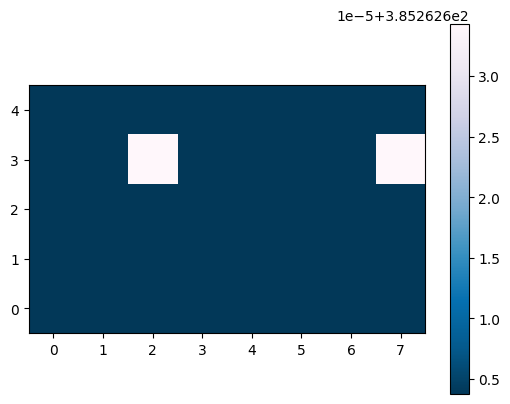

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 3),
 (3, 4),
 (3, 6),
 (3, 5),
 (4, 1),
 (4, 0),
 (4, 4),
 (4, 5),
 (4, 2),
 (4, 3),
 (4, 6),
 (4, 7),
 (3, 7),
 (3, 2)]

In [74]:
## S4 RMSE
s4_i = np.sqrt((s3_i**2) + s2_i)
print("RMSE: ", s4_i)
plt.imshow(s4_i, origin="lower", cmap="PuBu_r")
plt.colorbar()
plt.show()

all_important_pixels_s4 = get_top_n_pixels(s4_i, instance.shape[1]*instance.shape[2])[::-1]
all_important_pixels_s4

In [3]:
"""#### ***Spatial-RISE: Framework***"""

def rise_spatial_explaine(nr_instance, data_test_image, data_test_OHE, models, channel,
                          N, generate_masks_fn, seed, perturb_instance_fn, calculate_saliency_map_fn, H_station=390.0, **kwargs):
  print(f"############################### RISE-Spatial on Instance #{nr_instance} ###########################")
  instance    = copy.deepcopy(data_test_image[nr_instance])
  x3_instance = copy.deepcopy(data_test_OHE[nr_instance])

  input_size = (instance.shape[1], instance.shape[2])

  masks = generate_masks_fn(N, input_size, seed, **kwargs)
  perturbed_instances = perturb_instance_fn(instance, masks, channel)

  # Predizione su Istanza Originale
  pred_original = ensemble_predict(models, instance, x3_instance)
  # Predizioni su Istanze Perturbate
  preds_masked = ensemble_predict(models, perturbed_instances, x3_instance)

  # Denormalizzazione Output Black-Box con H_station 
  denorm_pred_original = (pred_original * vott_target_test_std) + vott_target_test_mean
  denorm_preds_masked  = [(pred_masked * vott_target_test_std) + vott_target_test_mean for pred_masked in preds_masked]
  denormalized_H_pred_original = H_station - denorm_pred_original
  denormalized_H_preds_masked  = [H_station - denorm_pred_masked for denorm_pred_masked in denorm_preds_masked]
  # Pesi delle Maschere
  weights = np.concatenate(denormalized_H_preds_masked, axis=0)

  ### S1 
  s1_i = calculate_saliency_map_fn(N, weights, masks)
  ### S2
  s2_i = calculate_saliency_map_fn(N, weights**2, masks) - (s1_i**2)
  ### S3 (BIAS)
  s3_i = (s1_i - denormalized_H_pred_original)
  ### S4 (RMSE)
  s4_i = np.sqrt((s3_i**2) + s2_i)
  print(f"############### Processo completato. Mappa di salienza generata per Istanza #{nr_instance} ###############")

  return np.squeeze(s1_i), np.squeeze(s2_i), np.squeeze(s3_i), np.squeeze(s4_i)

In [58]:
def plot_frame(frame, title="", cmap="PuBu"):
    plt.imshow(frame, origin="lower", cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [55]:
nr_instance = 0
models = vott_lstm_models_loaded
seed = 42
channel_prec = 0

N = 1000
h,w = 2,4
p   = 0.5

s1_0, s2_0, s3_0, s4_0 = rise_spatial_explaine(nr_instance, vottignasco_test_image, vottignasco_test_OHE, models, channel_prec,
                                               N, generate_rise_masks_2d, seed, multiplicative_uniform_noise_onechannel, calculate_saliency_map_ev_masks, h=h, w=w, p=p)



############################### RISE-Spatial on Instance #0 ###########################
############### Processo completato. Mappa di salienza generata per Istanza #0 ###############


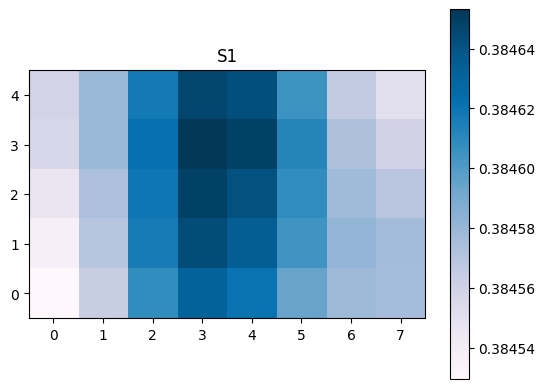

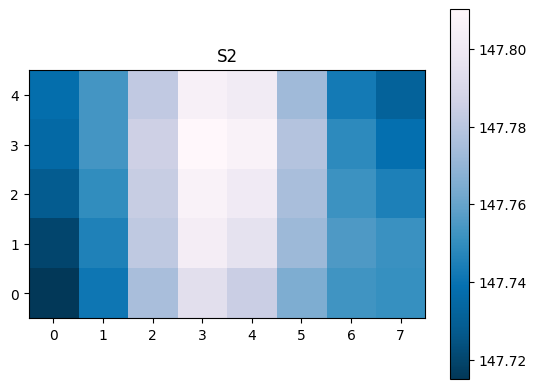

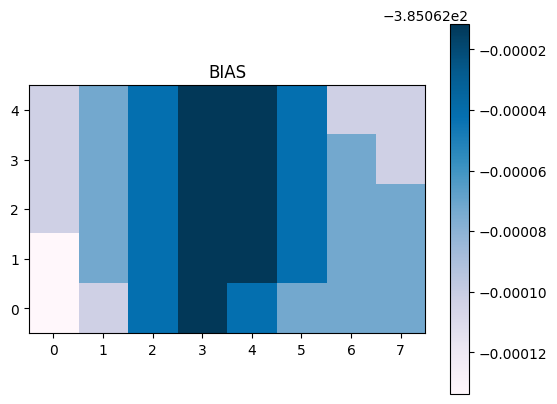

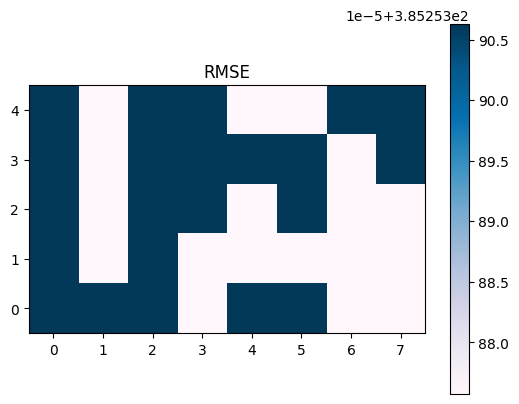

In [63]:
plot_frame(s1_0, cmap="PuBu", title="S1")
plot_frame(s2_0, cmap="PuBu_r", title="S2")
plot_frame(s3_0, cmap="PuBu", title="BIAS")
plot_frame(s4_0, cmap="PuBu", title="RMSE")

In [4]:
"""#### ***Evaluation Metrics***"""


# def plot_insertion_curve(total_errors, auc, title="Insertion Metric Curve"):
#     """
#     Plotta la curva di metrica di insertion con l'errore medio quadratico.

#     :param total_errors: Lista dei valori dell'errore per ogni frazione di pixel inseriti.
#     :param auc: Valore dell'Area Under Curve (AUC) calcolato.
#     :param title: Titolo del grafico (default: "Insertion Metric Curve").
#     """

#     # Nuovo asse X normalizzato tra 0 e 1
#     x = np.linspace(0, 1, len(total_errors))

#     # Plot della curva dell'errore e dell'area sotto la curva (AUC)
#     plt.figure(figsize=(7, 5))
#     plt.plot(x, total_errors, marker='o', linestyle='-', color='blue')

#     # Pallini blu sui punti della curva
#     plt.scatter(x, total_errors, color='blue', zorder=3)

#     # Area sotto la curva
#     plt.fill_between(x, total_errors, color='skyblue', alpha=0.4)

#     # Testo "Error curve" in alto a dx con font più piccolo
#     plt.legend(['Error curve'], loc='upper right', fontsize=9)

#     # Testo AUC appena sotto "Error curve"
#     plt.text(x[-1] - 0.02, max(total_errors) * 0.9,
#              f'AUC: {auc:.2f}',
#              horizontalalignment='right',
#              fontsize=8,
#              bbox=dict(facecolor='white', alpha=0.5))

#     # Etichette assi
#     plt.xlabel('Fraction of pixels inserted')
#     plt.ylabel('Mean Squared Error')

#     # Titolo del grafico
#     plt.title(title)

#     # Mostra il grafico
#     plt.show()


# def plot_deletion_curve(total_errors, auc, title="Deletion Metric Curve"):
#     """
#     Plotta la curva della metrica di deletion con l'errore medio quadratico.

#     :param total_errors: Lista dei valori dell'errore per ogni frazione di pixel rimossi.
#     :param auc: Valore dell'Area Under Curve (AUC) calcolato.
#     :param title: Titolo del grafico (default: "Deletion Metric Curve").
#     """

#     # Normalizzazione dell'asse X tra 0 e 1
#     x = np.linspace(0, 1, len(total_errors))

#     # Creazione del plot
#     plt.figure(figsize=(7,5))
#     plt.plot(x, total_errors, marker='o', linestyle='-', color='red')

#     # Pallini rossi sui punti della curva
#     plt.scatter(x, total_errors, color='red', zorder=3)

#     # Area sotto la curva
#     plt.fill_between(x, total_errors, color='lightcoral', alpha=0.4)

#     # Testo "Error curve" in alto a sx con font più piccolo
#     plt.legend(['Error curve'], loc='upper left', fontsize=9)

#     # Testo AUC appena sotto "Error curve"
#     plt.text(x[0] + 0.01, max(total_errors) * 0.88,
#              f'AUC: {auc:.2f}',
#              horizontalalignment='left',
#              fontsize=8,
#              bbox=dict(facecolor='white', alpha=0.5))

#     # Etichette degli assi
#     plt.xlabel('Fraction of pixels removed')
#     plt.ylabel('Mean Squared Error')

#     # Titolo del grafico
#     plt.title(title)

#     # Mostra il grafico
#     plt.show()


def calculate_auc(x, y):
    """
    Calcola l'area sotto la curva (AUC) utilizzando il metodo del trapezio.

    :param x: Valori dell'asse x (frazione dei pixel/frame inseriti).
    :param y: Valori dell'asse y (errori calcolati).
    :return: Area sotto la curva.
    """
    return np.trapz(y, x)


# Restituisce n-esimo percentile dei pixel più importanti delle mappa di salienza data in input
def get_top_n_pixels(saliency_map, n):
    # Appiattisci la mappa di salienza
    flat_saliency = saliency_map.flatten()
    # Ordina gli indici degli elementi in ordine decrescente di salienza
    sorted_indices = np.argsort(flat_saliency)[::-1]

    # Calcola il numero di colonne della mappa di salienza
    num_cols = saliency_map.shape[1]

    top_pixels = []
    for i in range(n):
        idx = sorted_indices[i]
        row, col = divmod(idx, num_cols)
        top_pixels.append((row, col))

    return top_pixels

"""##### ***Insertion***"""

def update_instance_with_pixels(current_instance, original_instance, x,y):
    """
    Aggiorna l'immagine inserendo i pixel più importanti.

    :param current_instance: Istanza corrente.
    :param original_instance: Istanza originale.
    :param x: coordinata x del pixel da inserire
    :param y: coordinata y del pixel da inserire
    :return: Istanza aggiornata con il superpixel.
    """
    new_current_instance = current_instance.copy()
    new_current_instance[:, x, y, 0] = original_instance[:, x, y, 0]

    return new_current_instance


def insertion(model, original_instance, x3_instance, sorted_per_importance_pixels_index, initial_blurred_instance, original_prediction, H_station=390.0):
    """
    Calcola la metrica di inserimento per una spiegazione data.

    :param model: Black-box.
    :param original_instance: Istanza originale.
    :param sorted_per_importance_pixels_index: Lista di liste di tutti i superpixel per importanza
    :param initial_blurred_images: Immagine iniziale con tutti i pixel a zero.
    :return: Lista degli errori ad ogni passo di inserimento.
    """

    # Lista per memorizzare le istanze a cui aggiungo pixel mano a mano. Inizializzata con istanza iniziale blurrata
    insertion_images = [initial_blurred_instance]

    # Predizione sull'immagine iniziale (tutti i pixel a zero)
    I_prime = copy.deepcopy(initial_blurred_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel aggiunti in maniera graduale
    for x,y in sorted_per_importance_pixels_index:
        I_prime = update_instance_with_pixels(I_prime, original_instance, x,y)
        insertion_images.append(I_prime)

    insertion_images = [img.astype(np.float32) for img in insertion_images]
    # Calcolo le predizioni sulle istanze a cui ho aggiunto i pixel in maniera graduale
    new_predictions = ensemble_predict(model, insertion_images, x3_instance)
    denorm_new_predictions  = [(new_prediction * vott_target_test_std)+ vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]

    # Rispetto ad ogni suddetta predizione, calcolo il MSE rispetto la pred sull'istanza originaria (come da test-set). Ignora la prima che è sull'img blurrata originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions[1:]]

    initial_error = mean_squared_error(original_prediction, denormalized_H_new_predictions[0])
    print(f"Initial Prediction with Blurred Instance. Prediction: {denormalized_H_new_predictions[0]}, error: {initial_error}")
    only_inserted_pixel_new_predictions = denormalized_H_new_predictions[1:]

    for nr_pixel, error in enumerate(errors):
      print(f"Inserted Pixel: {sorted_per_importance_pixels_index[nr_pixel]}. Prediction: {only_inserted_pixel_new_predictions[nr_pixel]}, error: {error}")

    total_errors = [initial_error] + errors # Errore iniziale + errori su tutti i pixel inseriti

    # # Nuovo asse X
    x = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC con il nuovo asse x
    auc = calculate_auc(x, total_errors)
    print(f"Area under the curve (AUC): {auc}")
    return total_errors,auc

def update_image_by_removing_pixels(current_instance, x, y, std_zero_value=-0.6486319166678826):
    """
    Aggiorna l'immagine rimuovendo i pixel x,y indicati.

    :param current_instance: istanza corrente.
    :param x: coordinata x del pixel da rimuovere
    :param y: coordinata y del pixel da rimuovere
    :return: Istanza aggiornata con x,y rimossi su tutti time-step.
    """
    new_instance = copy.deepcopy(current_instance)
    new_instance[:, x, y, 0] = std_zero_value # Imposta i pixel a zero normalizzato per Prec
    return new_instance

def deletion(models, original_instance, x3_instance, sorted_per_importance_pixels_index, original_prediction, H_station=390.0):
    """
    Calcola la metrica di rimozione per una spiegazione data.

    :param models: Lista di modelli pre-addestrati.
    :param original_instance: Immagine originale.
    :param x3_instance: Codifica one-hot per la previsione.
    :param sorted_per_importance_pixels_index: Indici dei pixel in ordine di importanza.
    :return: Lista degli errori, auc ad ogni passo di rimozione.
    """
    # Lista per memorizzare le img a cui elimino gradualmente i pixels (per ogni time-step)
    deletion_images = []

    # Inizializzazione
    I_prime = copy.deepcopy(original_instance)

    # Aggiungere gradualmente i pixel (per ogni frame) più importanti. Ottengo una lista con tutte le img con i pixel rimossi
    for x, y in sorted_per_importance_pixels_index:
        I_prime = update_image_by_removing_pixels(I_prime, x, y)
        deletion_images.append(I_prime)

    # Calcolo della predizione su tutte le img a cui ho rimosso gradualmente i pixel
    new_predictions = ensemble_predict(models, deletion_images, x3_instance)
    denorm_new_predictions  = [new_prediction * vott_target_test_std + vott_target_test_mean for new_prediction in new_predictions]
    denormalized_H_new_predictions  = [H_station - denorm_new_prediction for denorm_new_prediction in denorm_new_predictions]
    # Calcolo del mse rispetto la predizione originale
    errors = [mean_squared_error(original_prediction, masked_pred) for masked_pred in denormalized_H_new_predictions]

    initial_error = 0.0
    print(f"Initial Prediction with Original Images, prediction: {original_prediction}, error: {initial_error}")
    for nr_pixel, error in enumerate(errors):
        print(f"Removed pixel {sorted_per_importance_pixels_index[nr_pixel]}, new prediction: {denormalized_H_new_predictions[nr_pixel]}, error: {error}")

    total_errors = [initial_error] + errors  # Errore iniziale + errori su tutti i pixel rimossi

    # Normalizzare la frazione di pixel rimossi
    x = np.linspace(0, 1, len(total_errors))
    # Calcolo dell'AUC
    auc = calculate_auc(x, total_errors)

    print(f"Area under the curve (AUC): {auc}")
    return total_errors, auc

In [5]:
channel_prec = 0
models = vott_lstm_models_loaded
seed = 42
T,H,W,C = (104,5,8,3)
std_zero_value = -0.6486319166678826
H_station = 390.0

N = 1000

#h_w_values = [(1,2),(2,1),(2,2),(2,3),(2,4)]
h_w_values = [(1,2)]
#p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
p_values = [0.5]

results_setups = []

len_test_set = len(vottignasco_test_image)

for h,w in h_w_values:
    #print(f"############################## Setup h,w: ({h},{w}) ##############################")
    for p in p_values:
        # Conserva tutte le sal_maps per tutto il Test-Set
        saliency_maps = np.zeros((len_test_set,4,H,W))
        # Errori e AUC Insertion/Deletion tutto il Test-Set
        errors_insertion_all_testset = np.zeros((len_test_set,4, H*W+1))
        auc_insertion_all_testset    = np.zeros((len_test_set,4, 1))
        errors_deletion_all_testset  = np.zeros((len_test_set,4, H*W+1))
        auc_deletion_all_testset     = np.zeros((len_test_set,4, 1))

        p_str = str(p).replace(".", "")
        param_combination = f"h{h}_w{w}_p{p_str}"
        print(f"############################## Setup - > parameters combination: {param_combination} ##############################")  

        execution_times = []
        
        for nr_instance,_ in enumerate(vottignasco_test_image):
            print(f"###################### Explanation for Instance #{nr_instance} ####################################")
            time_start = datetime.datetime.now()

            s1_i,s2_i,s3_i,s4_i = rise_spatial_explaine(nr_instance, vottignasco_test_image, vottignasco_test_OHE, models, channel_prec,
                                                        N, generate_rise_masks_2d, seed, multiplicative_uniform_noise_onechannel, calculate_saliency_map_ev_masks, H_station, h=h, w=w, p=p)
            
            time_end = datetime.datetime.now()
            exec_time = (time_end - time_start).total_seconds()
            
            execution_times.append(exec_time)

            saliency_maps[nr_instance][0] = s1_i
            saliency_maps[nr_instance][1] = s2_i
            saliency_maps[nr_instance][2] = s3_i
            saliency_maps[nr_instance][3] = s4_i

            instance    = copy.deepcopy(vottignasco_test_image[nr_instance])
            x3_instance = copy.deepcopy(vottignasco_test_OHE[nr_instance])

            # Insertion s2,s3,s4
            # Video blurrato da cui partire per l'Insertion. Tutti i pixel di Prec su std_zero_value
            initial_blurred_instance = copy.deepcopy(instance)
            initial_blurred_instance[:,:,:,channel_prec] = std_zero_value

            original_instance = copy.deepcopy(instance)
            original_prediction = ensemble_predict(models, original_instance, x3_instance)
            denormalized_H_original_prediction = H_station - (original_prediction * vott_target_test_std + vott_target_test_mean)
            print(f"Original Prediction: {denormalized_H_original_prediction}")

            all_important_pixels_s2 = get_top_n_pixels(s2_i, instance.shape[1]*instance.shape[2])[::-1]
            all_important_pixels_s3 = get_top_n_pixels(np.abs(s3_i), instance.shape[1]*instance.shape[2])[::-1]
            all_important_pixels_s4 = get_top_n_pixels(s4_i, instance.shape[1]*instance.shape[2])[::-1]

                     
            errors_insertion_s2,auc_insertion_s2 = insertion(models, original_instance, x3_instance, all_important_pixels_s2, initial_blurred_instance, denormalized_H_original_prediction) # s2   
            errors_insertion_s3,auc_insertion_s3 = insertion(models, original_instance, x3_instance, all_important_pixels_s3, initial_blurred_instance, denormalized_H_original_prediction) # s3
            errors_insertion_s4,auc_insertion_s4 = insertion(models, original_instance, x3_instance, all_important_pixels_s4, initial_blurred_instance, denormalized_H_original_prediction) # s4
            #print(f"Errors Insertion: {errors_insertion}")
            #print(f"AUC Insertion: {auc_insertion}")

            for nr_error in range (0, (H*W+1)):
                errors_insertion_all_testset[nr_instance][1][nr_error] = errors_insertion_s2[nr_error]
                errors_insertion_all_testset[nr_instance][2][nr_error] = errors_insertion_s3[nr_error]
                errors_insertion_all_testset[nr_instance][3][nr_error] = errors_insertion_s4[nr_error]
            #for nr_error, error in enumerate(errors_insertion):
            #    errors_insertion_all_testset[nr_instance][nr_error] = error
            
            auc_insertion_all_testset[nr_instance][1] = auc_insertion_s2
            auc_insertion_all_testset[nr_instance][2] = auc_insertion_s3
            auc_insertion_all_testset[nr_instance][3] = auc_insertion_s4

            # Deletion
            errors_deletion_s2,auc_deletion_s2 = deletion(models, original_instance, x3_instance, all_important_pixels_s2, denormalized_H_original_prediction) # s2
            errors_deletion_s3,auc_deletion_s3 = deletion(models, original_instance, x3_instance, all_important_pixels_s3, denormalized_H_original_prediction) # s3
            errors_deletion_s4,auc_deletion_s4 = deletion(models, original_instance, x3_instance, all_important_pixels_s4, denormalized_H_original_prediction) # s4
            #print(f"Errors Deletion: {errors_deletion}")
            #print(f"AUC Deletion: {auc_deletion}")

            for nr_error in range (0, (H*W+1)):
                errors_deletion_all_testset[nr_instance][1][nr_error] = errors_deletion_s2[nr_error]
                errors_deletion_all_testset[nr_instance][2][nr_error] = errors_deletion_s3[nr_error]
                errors_deletion_all_testset[nr_instance][3][nr_error] = errors_deletion_s4[nr_error]
            
            auc_deletion_all_testset[nr_instance][1] = auc_deletion_s2
            auc_deletion_all_testset[nr_instance][2] = auc_deletion_s3
            auc_deletion_all_testset[nr_instance][3] = auc_deletion_s4

        print(f"#################################### END for all Instance in Test-Set for {param_combination} ####################################")

        result = {
                "saliency_maps": saliency_maps,
                "errors_insertion": errors_insertion_all_testset,
                "auc_insertion": auc_insertion_all_testset,
                "errors_deletion": errors_deletion_all_testset,
                "auc_deletion": auc_deletion_all_testset,
                "parameters_comb": param_combination,
                "execution_times": execution_times  # Lista di nr_instances (105) tempi di exec per ogni istanza
            }

        results_setups.append(result)

        print(f"############################# END FOR ALL INSTANCES ###############################################")
        # SALVO LA LISTA DI results
        # path_to_save_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/spatial/results/rise_original_multiplicative_norm_zero/results_setup_new_h_w_diff_pred.pkl")
        #path_to_save_results = f"{RESULT_DIR}/rise_spatial_results_all_setup_diff_pred.pkl"
        path_to_save_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/spatial/results/results_setup_new_h_w_diff_pred.pkl")

        # Salvataggio della lista results in un file pickle
        with open(path_to_save_results, 'wb') as f:
            pickle.dump(results_setups, f)

print("############################# END FOR ALL SETUPS ##########################################################################")

############################## Setup - > parameters combination: h1_w2_p05 ##############################
###################### Explanation for Instance #0 ####################################
############################### RISE-Spatial on Instance #0 ###########################
############### Processo completato. Mappa di salienza generata per Istanza #0 ###############
Original Prediction: [[385.4217]]
Initial Prediction with Blurred Instance. Prediction: [384.0693], error: 1.828949213027954
Inserted Pixel: (0, 0). Prediction: [384.03873], error: 1.9125924110412598
Inserted Pixel: (1, 0). Prediction: [384.08118], error: 1.796980857849121
Inserted Pixel: (3, 0). Prediction: [384.03934], error: 1.9109046459197998
Inserted Pixel: (2, 0). Prediction: [384.0968], error: 1.7553339004516602
Inserted Pixel: (4, 0). Prediction: [384.09296], error: 1.7655376195907593
Inserted Pixel: (2, 1). Prediction: [384.17645], error: 1.5506207942962646
Inserted Pixel: (1, 1). Prediction: [384.196], err

In [6]:
path_to_load_results = os.path.join(work_path, f"Water_Resources/rise-video/XAI/spatial/results/results_setup_new_h_w_diff_pred.pkl")
# Load della lista results
with open(path_to_load_results, 'rb') as file:
    result = pickle.load(file)

In [25]:
result[0]["execution_times"]

[5.829945]